In [1]:
import json

In [3]:
with open("results/out_logic.json", 'r') as f:
    res = json.load(f)

In [4]:
res.keys()

dict_keys(['inputs', 'inputs_depth', 'ground_truth', 'responses_orig', 'responses_ft'])

In [5]:
import pandas as pd

df = pd.DataFrame()

df['ground_truth'] = res["ground_truth"]
df['responses_ft'] = res["responses_ft"]
df['responses_orig'] = res["responses_orig"]
df['depth'] = res["inputs_depth"]

In [6]:
df['ground_truth_true'] = df['ground_truth'].apply(lambda x: x=="true")
df['ground_truth_false'] = df['ground_truth'].apply(lambda x: x=="false")
df['ground_truth_uncertain'] = df['ground_truth'].apply(lambda x: x=="uncertain")


In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['ground_truth_encoded'] = le.fit_transform(df["ground_truth"])
# df['ground_truth_encoded']

In [8]:
test_len = len("You must then determine whether the statement is true or false.")

In [9]:
df["index_reply_ft"] = df['responses_ft'].apply(lambda x: x.find("You must then determine whether the statement is true or false."))
df["index_reply_orig"] = df['responses_orig'].apply(lambda x: x.find("You must then determine whether the statement is true or false."))

In [10]:
df['cut_resp_ft'] = df['responses_ft'].apply(lambda x: x[x.find("You must then determine whether the statement is true or false.") + test_len:])
df['cut_resp_orig'] = df['responses_orig'].apply(lambda x: x[x.find("You must then determine whether the statement is true or false.")+test_len:])

In [72]:
import nltk
from nltk.tokenize import sent_tokenize
from tqdm.notebook import tqdm
import spacy

tqdm.pandas()

nlp = spacy.load("en_core_web_sm") # Load a small English model

# df['testing'] = df['cut_resp_orig'].apply(lambda x:sent_tokenize(x))
df['testing'] = df['cut_resp_orig'].progress_apply(lambda x:[y.text for y in nlp(x).sents])


  0%|          | 0/6000 [00:00<?, ?it/s]

In [73]:
from itertools import chain
from collections import Counter

c = Counter(chain(*df['testing'].tolist()))

In [92]:
c.most_common(100)

[('##', 6126),
 ('input that provides further context.\n', 6000),
 ('Write a response that appropriately completes the request.\n\n### Instruction:\nYou are a scientist, proficient in logic.',
  6000),
 ('Read next premises and evaluate whether following statement is true, false, or uncertain, based solely on the premises. \n',
  6000),
 ('Your response can be only true, false or uncertain.\n\n', 4003),
 ('The statement is neither true nor false.', 1960),
 ('3.', 1860),
 ('Statement above is true.', 1803),
 ('2.', 1744),
 ('True or False?', 1736),
 ('### Premises:\n', 1700),
 ('True.', 1592),
 ('4.', 1588),
 ('The statement above is true.', 1493),
 ('And so on.', 1400),
 ('5.', 1387),
 ('The statement is false.', 1340),
 ('8.', 1335),
 ('6.', 1331),
 ('10.', 1309),
 ('12.', 1288),
 ('14.', 1283),
 ('11.', 1280),
 ('13.', 1259),
 ('16.', 1249),
 ('9.', 1237),
 ('15.', 1234),
 ('17.', 1214),
 ('18.', 1192),
 ('19.', 1182),
 ('20.', 1182),
 ('The statement is true.', 1155),
 ('22.', 1155)

In [94]:
df['conv_ft_true'] = df['cut_resp_ft'].apply(lambda x: "the statement is true" in x.lower() or "statement above is true" in x.lower())
df['conv_ft_false'] = df['cut_resp_ft'].apply(lambda x: "the statement is false" in x.lower() or "the statement is untrue" in x.lower() or "statement above is false" in x.lower())
df['conv_ft_uncertain'] = df['cut_resp_ft'].apply(lambda x: "the statement is uncertain" in x.lower() or "the statement is neither true nor false" in x.lower() or "statement above is uncertain" in x.lower() or "the statement is uncertain because it is neither true nor false" in x.lower())


df['conv_orig_true'] = df['cut_resp_orig'].apply(lambda x: "the statement is true" in x.lower() or "statement above is true" in x.lower())
df['conv_orig_false'] = df['cut_resp_orig'].apply(lambda x: "the statement is false" in x.lower() or "the statement is untrue" in x.lower() or "statement above is false" in x.lower())
df['conv_orig_uncertain'] = df['cut_resp_orig'].apply(lambda x: "the statement is uncertain" in x.lower() or "the statement is neither true nor false" in x.lower() or "statement above is uncertain" in x.lower() or "the statement is uncertain because it is neither true nor false" in x.lower())

In [95]:
df["unique_answer_ft"] = (df[["conv_ft_true", "conv_ft_false", "conv_ft_uncertain"]].sum(axis=1) == 1).values
df["unique_answer_orig"] = (df[["conv_orig_true", "conv_orig_false", "conv_orig_uncertain"]].sum(axis=1) == 1).values

In [96]:
df['ft_pred_name'] = df[["conv_ft_true", "conv_ft_false", "conv_ft_uncertain"]].idxmax(axis=1)
df['orig_pred_name'] = df[["conv_orig_true", "conv_orig_false", "conv_orig_uncertain"]].idxmax(axis=1)

In [97]:
mapper = {"conv_ft_true":"true", "conv_ft_false":"false", "conv_ft_uncertain":"uncertain", "conv_orig_true":"true", "conv_orig_false":"false", "conv_orig_uncertain":"uncertain"}
df['ft_pred'] = df['ft_pred_name'].apply(lambda x: mapper[x])
df['orig_pred'] = df['orig_pred_name'].apply(lambda x: mapper[x])

In [98]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

f1_finetuning = []
number_parsed_ft = []
for d in range(1, 7):
    df_subset = df[df['depth']==d]
    predictions_ft = le.transform(df_subset[df_subset["unique_answer_ft"]]['ft_pred'])
    number_parsed_ft.append(len(predictions_ft))
    ground_truth_ft = df_subset[df_subset["unique_answer_ft"]]['ground_truth_encoded']
    f1_finetuning.append(f1_score(predictions_ft, ground_truth_ft, average = 'macro'))
    print(d, classification_report(predictions_ft, ground_truth_ft))

1               precision    recall  f1-score   support

           0       0.22      0.43      0.29        28
           1       0.74      0.38      0.50       136
           2       0.09      0.24      0.13        25

    accuracy                           0.37       189
   macro avg       0.35      0.35      0.31       189
weighted avg       0.58      0.37      0.42       189

2               precision    recall  f1-score   support

           0       0.13      0.26      0.17        23
           1       0.71      0.33      0.45       106
           2       0.10      0.36      0.16        14

    accuracy                           0.32       143
   macro avg       0.32      0.32      0.26       143
weighted avg       0.56      0.32      0.38       143

3               precision    recall  f1-score   support

           0       0.21      0.41      0.28        22
           1       0.76      0.33      0.46        85
           2       0.05      0.20      0.08        10

    accuracy  

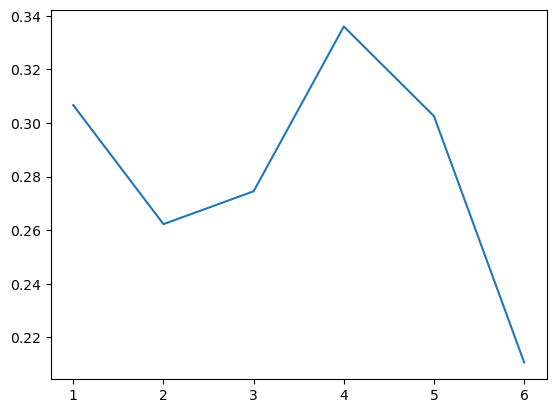

In [99]:
import matplotlib.pyplot as plt 

plt.plot(range(1, 7), f1_finetuning)

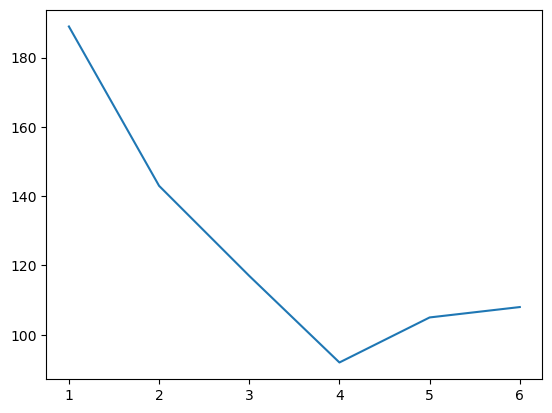

In [100]:
import matplotlib.pyplot as plt 

plt.plot(range(1, 7), number_parsed_ft)

In [101]:
from sklearn.metrics import classification_report

In [108]:
predictions_ft = le.transform(df[df["unique_answer_ft"]]['ft_pred'])
ground_truth_ft = df[df["unique_answer_ft"]]['ground_truth_encoded']

print(classification_report(predictions_ft, ground_truth_ft))

              precision    recall  f1-score   support

           0       0.19      0.37      0.25       118
           1       0.74      0.33      0.46       558
           2       0.09      0.32      0.14        78

    accuracy                           0.34       754
   macro avg       0.34      0.34      0.28       754
weighted avg       0.59      0.34      0.39       754



In [103]:
from sklearn.metrics import f1_score

f1_orig = []
number_parsed_orig = []
for d in range(1, 7):
    df_subset = df[df['depth']==d]
    predictions_orig = le.transform(df_subset[df_subset["unique_answer_orig"]]['orig_pred'])
    number_parsed_orig.append(len(predictions_orig))
    ground_truth_orig = df_subset[df_subset["unique_answer_orig"]]['ground_truth_encoded']
    f1_orig.append(f1_score(predictions_orig, ground_truth_orig, average = 'macro'))
    print(d, classification_report(predictions_orig, ground_truth_orig))

1               precision    recall  f1-score   support

           0       0.18      0.38      0.24        26
           1       0.78      0.41      0.54       124
           2       0.09      0.20      0.13        25

    accuracy                           0.38       175
   macro avg       0.35      0.33      0.30       175
weighted avg       0.60      0.38      0.44       175

2               precision    recall  f1-score   support

           0       0.19      0.31      0.23        26
           1       0.79      0.37      0.50       100
           2       0.15      0.44      0.22        18

    accuracy                           0.37       144
   macro avg       0.37      0.37      0.32       144
weighted avg       0.60      0.37      0.42       144

3               precision    recall  f1-score   support

           0       0.37      0.55      0.44        33
           1       0.76      0.42      0.54        89
           2       0.15      0.40      0.22        15

    accuracy  

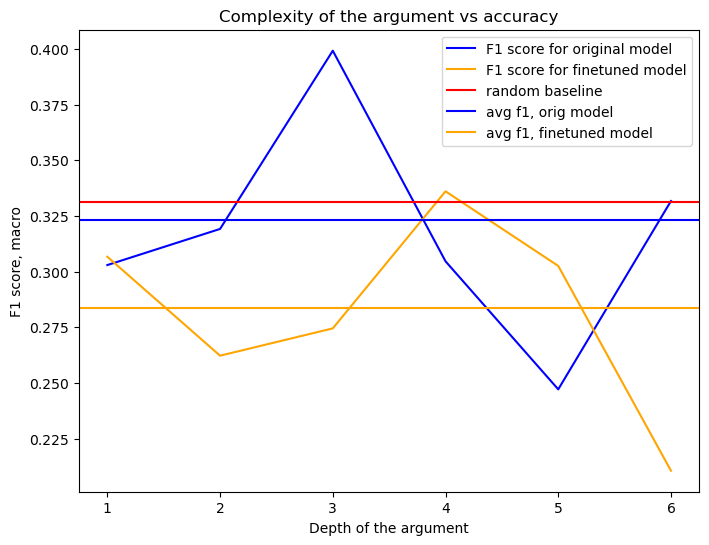

In [145]:
import matplotlib.pyplot as plt 
import random
import numpy as np

fig = plt.figure(figsize = (8,6))

plt.plot(range(1, 7), f1_orig, label = "F1 score for original model", color = 'blue')
plt.plot(range(1, 7), f1_finetuning, label = "F1 score for finetuned model", color = 'orange')


random_baseline_value = np.mean([f1_score(np.random.randint(0, 3, len(ground_truth_orig)), ground_truth_orig, average = "macro") for x in range(100)])

plt.axhline(random_baseline_value, label = 'random baseline', color = 'red')

predictions_orig = le.transform(df[df["unique_answer_orig"]]['orig_pred'])
ground_truth_orig = df[df["unique_answer_orig"]]['ground_truth_encoded']
plt.axhline(f1_score(predictions_orig, ground_truth_orig, average = 'macro'), label = 'avg f1, orig model', color = 'blue')

predictions_ft = le.transform(df[df["unique_answer_ft"]]['ft_pred'])
ground_truth_ft = df[df["unique_answer_ft"]]['ground_truth_encoded']
plt.axhline(f1_score(predictions_ft, ground_truth_ft, average = 'macro'), label = 'avg f1, finetuned model', color = 'orange')

plt.xlabel("Depth of the argument")
plt.ylabel("F1 score, macro")

plt.title("Complexity of the argument vs accuracy")
plt.legend()
plt.savefig("complexity_vs_f1.png", bbox_inches = 'tight')
plt.show()

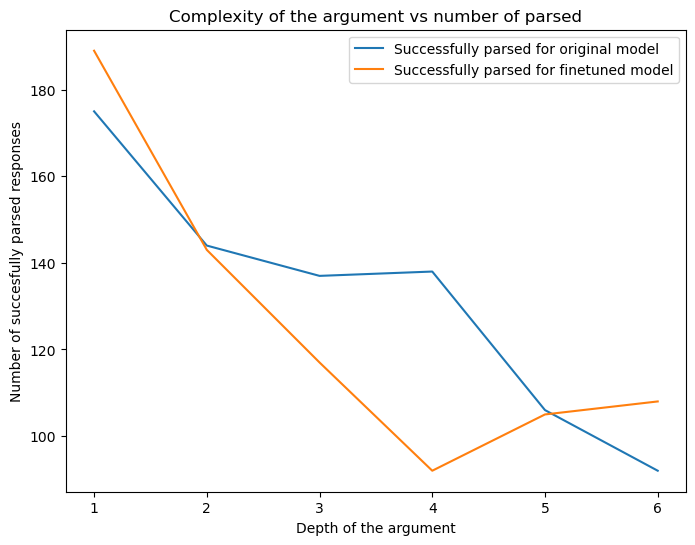

In [144]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize = (8, 6))
plt.plot(range(1, 7), number_parsed_orig, label = "Successfully parsed for original model")
plt.plot(range(1, 7), number_parsed_ft, label = "Successfully parsed for finetuned model")

plt.xlabel("Depth of the argument")
plt.ylabel("Number of succesfully parsed responses")

plt.title("Complexity of the argument vs number of parsed")
plt.legend()
plt.savefig("number_parsed.png", bbox_inches = 'tight')
plt.legend()

In [112]:
predictions_orig = le.transform(df[df["unique_answer_orig"]]['orig_pred'])
ground_truth_orig = df[df["unique_answer_orig"]]['ground_truth_encoded']

In [113]:
print(classification_report(predictions_orig, ground_truth_orig))

              precision    recall  f1-score   support

           0       0.23      0.39      0.29       142
           1       0.78      0.40      0.53       569
           2       0.10      0.31      0.15        81

    accuracy                           0.39       792
   macro avg       0.37      0.37      0.32       792
weighted avg       0.61      0.39      0.45       792



0.33574038724129557